In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Get_groups import phase_diagram,make_meanr

from TO_sim.To_Draw import Draw_avg_vel_r
from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import parmap
from pprint import pprint

## cluster check2
cluster가 생성될때 메인 클러스터가 2개로 분화된다면 기존 알고리즘에서는 확인하기 어렵다는 단점이 있다

* 알고리즘을 2개를 사용해 클러스터의 확인 성능을 향상시켜 보자
    - cluster의 개수로 1차 판별
    - cluster의 안정성을 가지고 2차 판별

In [187]:
def cluster_os(avg_dtheta,N,cidx=False,dt=0.1):
    def to_cluster_barg(idx,peaks_new):
        C = idx,idx+1
        arg_C = peaks_new[C[0]],peaks_new[C[1]]
        cluster = np.arange(arg_C[0],arg_C[1])
        return cluster
    def to_cstability(x,diff_dtheta):
        try:
            return np.mean(diff_dtheta[x[1:]])
        except IndexError:
            return np.nan
    def to_mean_avg_d_o(x,avg_dtheta,index):
        try:
            return np.mean(avg_dtheta[index][x])
        except IndexError:
            return np.nan
    iter_time = 20*int(1/dt)*5
    num = 0
    for index in range(-iter_time,0):
        arg = np.argsort(avg_dtheta[index])
        SD = avg_dtheta[index][arg]
        diff_dtheta = np.diff([SD[0],*SD,SD[-1]])
        peaks, P  = find_peaks(diff_dtheta, height=0.01)
        
        # peaks = peaks[np.where((peaks<N)&(peaks>1))]

        try:
            peaks_new = np.array([peaks[0],*peaks])
        except IndexError:
            peaks_new = np.array([0,N])

        psize = np.diff(peaks_new)
        arg_psize = np.argsort(psize)[::-1]
        sort_psize = np.sort(psize)[::-1]
        clusters = np.array([to_cluster_barg(arg,peaks_new) for arg in arg_psize],dtype=object)[:10]
        try:
            if len(clusters) == 1:
                clusters = np.array([np.arange(peaks_new[0],N)])
            c_stability = np.array(list(map(to_cstability,clusters,[diff_dtheta]*len(clusters))))
            mean_omega = np.array(list(map(to_mean_avg_d_o,clusters,[avg_dtheta]*len(clusters),[index]*len(clusters))))
            if num==0:
                psize_array = sort_psize[:10]
                cluster_array = clusters
                c_stability_array = c_stability
                mean_omega_array = mean_omega
                arg_array = arg

                num+=1
            else:
                cluster_array = np.c_[cluster_array,clusters]
                psize_array = np.c_[psize_array,sort_psize[:10]]
                c_stability_array = np.c_[c_stability_array,c_stability]
                mean_omega_array = np.c_[mean_omega_array,mean_omega]
                arg_array = np.c_[arg_array,arg]
        except ValueError:
            pass
            

    Is_group, = np.where((np.std(psize_array,axis=1) == 0)&(psize_array[:,-1]>3))
    check_2nd = False
    mean_group_s = np.mean(c_stability_array,axis=1)
    Is_group2, = np.where((mean_group_s<1e-3)&(psize_array[:,-1]>3))
    Is_group = np.intersect1d(Is_group,Is_group2)
    if len(Is_group)==0:
        check_2nd = True
        mean_group_s = np.mean(c_stability_array,axis=1)
        Is_group, = np.where((mean_group_s<1e-2)&(psize_array[:,-1]>5))
    CM_O = np.mean(mean_omega_array[Is_group],axis=1)
    sCM_O = np.sort(CM_O)
    sCM_Oidx = np.argsort(CM_O)

    CM_S = np.mean(psize_array[Is_group],axis=1)[sCM_Oidx]
    if cidx == True:
        C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])
        return CM_S,sCM_O,C_idx
    else:
        return CM_S,sCM_O

In [188]:
def C_rsmso(K,m,N,theta_init,omega,pdtheta,t_end=5000,dt=0.1):
    t = np.arange(0,t_end,dt)
    theta, dtheta,rs = mf2(K,m=m,N=N,t_array=t,p_theta=theta_init,p_dtheta= pdtheta,p_omega=omega,result_time = int((t_end)-(600))*int(1/dt))
    r_duration = rs[-5000:]
    r = np.mean(r_duration)
    rstd = np.std(r_duration)
    rMM = np.max(r_duration)-np.min(r_duration)

    sum_time = 500*int(1/dt)
    dtheta_c = np.cumsum(dtheta,axis=0)
    avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
    dtype = [('cluster size', int), ('cluster mean phase velocity', float)]
    CM_S,CM_O = cluster_os(avg_dtheta=avg_dtheta,N=N,dt=dt)
    CSO = np.array([(S,O) for S,O in zip(CM_S,CM_O)],dtype=dtype)
    return r,rstd,rMM,CSO


In [190]:
N = 500
seed = 10
K = 3.1
m = 6
theta_init,omega,_ = Normal(N,0,1,seed=seed)
omega = np.sort(omega) - np.mean(omega)
C_rsmso(K,m,N,theta_init,omega,0*omega,t_end=6000)

(0.4979350967073677,
 0.07563105469227177,
 0.29895354203799007,
 array([(282, 0.06363479), ( 18, 0.91787616)],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]))

In [ ]:
C_rsmso(K,m,N,theta_init,omega,omega,t_end=5000)


(0.5269236491266356,
 0.1523877532178848,
 0.44073103968032223,
 array([3018., 1137.,  249.]),
 array([-0.23529913,  0.68201267,  1.70248861]))

In [192]:
seed =10
N = 500
theta_random,omega,Kc = Normal(N,0,1,seed=seed)
# omega = omega - np.mean(omega)
omega = np.sort(omega) - np.mean(omega)
dt = 0.1
t_end = 6000
m = 6
K = 3.1
t = np.arange(0,t_end,dt)
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta= 0*omega,p_omega=omega,result_time = int((t_end)-(600))*int(1/dt))
if m == 0:
    dtheta = np.c_[dtheta[0],dtheta.T].T

In [193]:
r_duration = rs[-5000:]
r = np.mean(r_duration)
rstd = np.std(r_duration)
rMM = np.max(r_duration)-np.min(r_duration)

In [194]:
dtheta_c = np.cumsum(dtheta,axis=0)
r_c = np.cumsum(rs,axis=0)
sum_time = 500*int(1/dt)
t_sum = t[sum_time:]
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
avg_r = (r_c[sum_time:]-r_c[:-sum_time])/sum_time

In [195]:
    def to_cluster_barg(idx,peaks_new):
        C = idx,idx+1
        arg_C = peaks_new[C[0]],peaks_new[C[1]]
        cluster = np.arange(arg_C[0],arg_C[1])
        return cluster
    def to_cstability(x,diff_dtheta):
        try:
            return np.mean(diff_dtheta[x[1:]])
        except IndexError:
            return np.nan
    def to_mean_avg_d_o(x,avg_dtheta,index):
        try:
            return np.mean(avg_dtheta[index][x])
        except IndexError:
            return np.nan
    iter_time = 20*int(1/dt)*5
    num = 0
    for index in range(-iter_time,0):
        arg = np.argsort(avg_dtheta[index])
        SD = avg_dtheta[index][arg]
        diff_dtheta = np.diff([SD[0],*SD,SD[-1]])
        peaks, P  = find_peaks(diff_dtheta, height=0.01)
        
        # peaks = peaks[np.where((peaks<N)&(peaks>1))]

        try:
            peaks_new = np.array([peaks[0],*peaks])
        except IndexError:
            peaks_new = np.array([0,N])

        psize = np.diff(peaks_new)
        arg_psize = np.argsort(psize)[::-1]
        sort_psize = np.sort(psize)[::-1]
        clusters = np.array([to_cluster_barg(arg,peaks_new) for arg in arg_psize],dtype=object)[:10]
        try:
            if len(clusters) == 1:
                clusters = np.array([np.arange(peaks_new[0],N)])
            c_stability = np.array(list(map(to_cstability,clusters,[diff_dtheta]*len(clusters))))
            mean_omega = np.array(list(map(to_mean_avg_d_o,clusters,[avg_dtheta]*len(clusters),[index]*len(clusters))))
            if num==0:
                psize_array = sort_psize[:10]
                cluster_array = clusters
                c_stability_array = c_stability
                mean_omega_array = mean_omega
                arg_array = arg

                num+=1
            else:
                cluster_array = np.c_[cluster_array,clusters]
                psize_array = np.c_[psize_array,sort_psize[:10]]
                c_stability_array = np.c_[c_stability_array,c_stability]
                mean_omega_array = np.c_[mean_omega_array,mean_omega]
                arg_array = np.c_[arg_array,arg]
        except ValueError:
            pass
            

    Is_group, = np.where((np.std(psize_array,axis=1) == 0)&(psize_array[:,-1]>3))
    check_2nd = False
    mean_group_s = np.mean(c_stability_array,axis=1)
    Is_group2, = np.where((mean_group_s<1e-3)&(psize_array[:,-1]>3))
    Is_group = np.intersect1d(Is_group,Is_group2)
    if len(Is_group)==0:
        check_2nd = True
        Is_group, = np.where((np.std(psize_array,axis=1) == 0)&(psize_array[:,-1]>3))
    if len(Is_group)==0:
        check_3nd = True
        mean_group_s = np.mean(c_stability_array,axis=1)
        Is_group, = np.where((mean_group_s<1e-3)&(psize_array[:,-1]>5))
    CM_O = np.mean(mean_omega_array[Is_group],axis=1)
    sCM_O = np.sort(CM_O)
    sCM_Oidx = np.argsort(CM_O)


    C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])
    CM_S = np.mean(psize_array[Is_group],axis=1)[sCM_Oidx]

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_24404/1615764748.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])


In [196]:
Is_group,check_2nd,rstd

(array([0, 2]), False, 0.07563105469227177)

In [197]:
CM_S

array([282.,  18.])

(None, [<matplotlib.lines.Line2D at 0x175769610>])

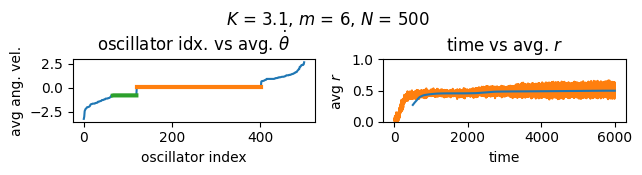

In [198]:
Draw_avg_vel_r(t_sum=t_sum,avg_r=avg_r,KmN=(K,m,N),avg_dtheta=avg_dtheta,Cidx=C_idx),plt.plot(t,rs,zorder=0)